Create bulk figures to search for the best cloud-free image in each year for our validation glaciers

In [171]:
import rasterio as rio
import numpy as np
import os
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import gc
import shapely
import xarray as xr
from rasterio.mask import mask

import sys
sys.path.append('../')
import snowFun

# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_validationlines = os.path.join(folder_AGVA, 'Validation', 'Snowline Traces')

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "01_rgi60_Alaska", "01_rgi60_Alaska.shp")
rgi_gdf = gpd.read_file(path_rgi)

### test opening one of our geojson files

In [199]:
# set file name/path
rgi_i = 'RGI60-01.08989'
name = f'{rgi_i[:5]}_{rgi_i[6:8]}_{rgi_i[9:]}.geojson'
line_path = os.path.join(folder_validationlines, name)

# decide which columns you want to drop
bad_cols = ['id', 'SLCFlag', 'cloudShadowFlag', 'notes', 'otherImageFlag', 'partialPickFlag']
snowlines_gdf = gpd.read_file(line_path).drop(bad_cols, axis=1).to_crs("EPSG:3338")

# add year as column
snowlines_gdf['Year'] = [int(i[:4]) for i in snowlines_gdf['Date']]
snowlines_gdf.head(10)

,Date,ImagePath,Satellite,Time,pointLat,pointLon,system:time_start,geometry,Year
0,2018-09-14,COPERNICUS/S2_HARMONIZED/20180914T211511_20180...,SENTINEL_2,21:15:59,61.262461,-149.001746,1536959759970,"MULTILINESTRING ((264760.998 1258480.891, 2647...",2018
1,2018-09-14,COPERNICUS/S2_HARMONIZED/20180914T211511_20180...,SENTINEL_2,21:15:59,61.262461,-149.001746,1536959759970,"MULTILINESTRING ((264760.998 1258480.891, 2647...",2018
2,2019-08-30,COPERNICUS/S2_HARMONIZED/20190830T211511_20190...,SENTINEL_2,21:18:32,61.262461,-149.001746,1567199912090,"MULTILINESTRING ((264747.240 1258457.290, 2647...",2019
3,2020-08-27,COPERNICUS/S2_HARMONIZED/20200827T212531_20200...,SENTINEL_2,21:28:34,61.262461,-149.001746,1598563714782,"MULTILINESTRING ((264594.795 1258540.558, 2647...",2020
4,2021-09-11,COPERNICUS/S2_HARMONIZED/20210911T212521_20210...,SENTINEL_2,21:28:24,61.262461,-149.001746,1631395704483,"MULTILINESTRING ((264567.698 1258527.438, 2646...",2021
5,2022-08-10,COPERNICUS/S2_HARMONIZED/20220810T213541_20220...,SENTINEL_2,21:38:38,61.262461,-149.001746,1660167518330,"MULTILINESTRING ((264677.645 1258558.843, 2647...",2022


### Delete duplicate information

In [220]:
# in some instances there will be multiple entries for a single date
# (when the user went back to edit a previous image's snowline)
# in this case, we only want to keep the entry that has the full record (so the one with the latest index)
snowlines_gdf = snowlines_gdf[~snowlines_gdf.duplicated(subset='Date', keep='last')]
snowlines_gdf.head()

,Date,ImagePath,Satellite,Time,pointLat,pointLon,system:time_start,geometry,Year
1,2018-09-14,COPERNICUS/S2_HARMONIZED/20180914T211511_20180...,SENTINEL_2,21:15:59,61.262461,-149.001746,1536959759970,"MULTILINESTRING ((264760.998 1258480.891, 2647...",2018
2,2019-08-30,COPERNICUS/S2_HARMONIZED/20190830T211511_20190...,SENTINEL_2,21:18:32,61.262461,-149.001746,1567199912090,"MULTILINESTRING ((264747.240 1258457.290, 2647...",2019
3,2020-08-27,COPERNICUS/S2_HARMONIZED/20200827T212531_20200...,SENTINEL_2,21:28:34,61.262461,-149.001746,1598563714782,"MULTILINESTRING ((264594.795 1258540.558, 2647...",2020
4,2021-09-11,COPERNICUS/S2_HARMONIZED/20210911T212521_20210...,SENTINEL_2,21:28:24,61.262461,-149.001746,1631395704483,"MULTILINESTRING ((264567.698 1258527.438, 2646...",2021
5,2022-08-10,COPERNICUS/S2_HARMONIZED/20220810T213541_20220...,SENTINEL_2,21:38:38,61.262461,-149.001746,1660167518330,"MULTILINESTRING ((264677.645 1258558.843, 2647...",2022


### Merge any multilinestring into single linestring geometries
we don't actually want to do this, so skip it

In [221]:
# function to take a shapely multilinestring (mls) and connect segments together to get a single linestring
def multi_to_single(mls):
    
    # make it iterable
    mls = list(mls.geoms)
    
    # get coordinates of every single points on all lines
    outcoords = []
    for ls in mls:
        for c in list(ls.coords):
            outcoords.append(c)

    # make single linestring out of these coordinates and return   
    return shapely.geometry.LineString(outcoords)

# Merge any MultiLineString into a single LineString
# for idx, row in snowlines_gdf.iterrows():
#     if row['geometry'].geom_type == 'MultiLineString':
#         snowlines_gdf.loc[idx,'geometry'] = multi_to_single(row['geometry'])

### plot the lines with the glacier outline also shown

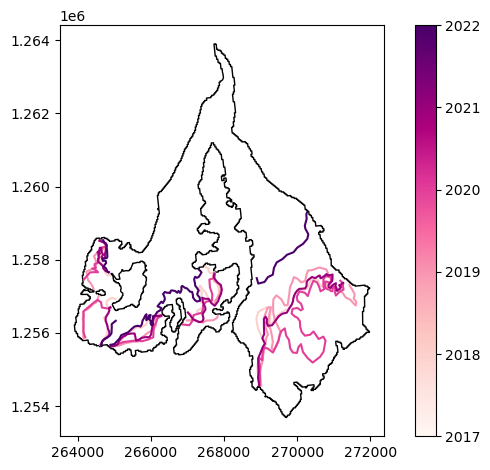

In [222]:
# get the rgi that these lines correspond to
rgi_i_gdf = rgi_gdf[rgi_gdf['RGIId']==rgi_i].to_crs("EPSG:3338")

# make figure
fig, axs = plt.subplots()
rgi_i_gdf.boundary.plot(ax=axs, edgecolor='black', linewidth=1)
snowlines_gdf.plot(ax=axs, column='Year', cmap="RdPu", vmin=2017, vmax=2022, legend=True)
plt.tight_layout()

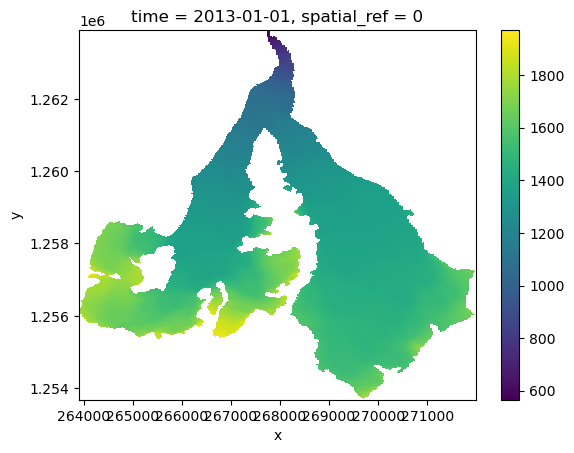

In [223]:
xr_dem = snowFun.get_year_DEM(rgi_i_gdf.geometry, 2013)
xr_dem = xr.where(xr_dem<=0, np.nan, xr_dem)[0]
xr_dem.plot()

### Lets plots the manually-mapped snowlines for each year on top of the automated end-of-summer snow cover product from each year

Red: Manual snowline
Black: Automated ELA


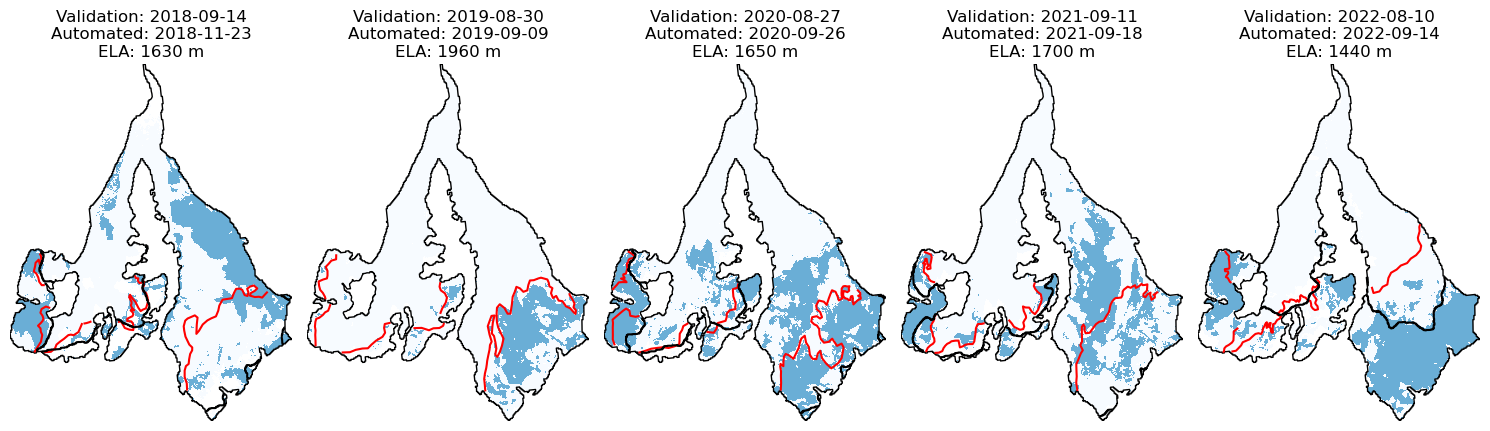

In [225]:
# open the annual accumulation area (AA) product for this rgi, and derived ELA
annual_aa_folder = os.path.join(folder_AGVA, 'Derived Products', 'S2', 'Annual AAs')
annual_aa_path = os.path.join(annual_aa_folder, f"S2_{rgi_i}_2018_2022_annual_AAs.nc")
annual_aa_xr = xr.open_dataset(annual_aa_path).accumulation_area

annual_ela_folder = os.path.join(folder_AGVA, 'Derived Products', 'S2', 'csv')
annual_ela_path = os.path.join(annual_ela_folder, f"S2_{rgi_i}_2018_2022_annual_AAs.csv")
annual_ela_df = pd.read_csv(annual_ela_path)

# get the dem
xr_dem = snowFun.get_year_DEM(rgi_i_gdf.geometry, 2013)
xr_dem = xr.where(xr_dem<=0, np.nan, xr_dem)[0]

### make a figure with 5 subplots
fig, axs = plt.subplots(1,5, figsize=(15,5))
for i in range(5):
    y=i+2018
    ax=axs[i]
    
    # grab the automated aa for this year
    aa_y = annual_aa_xr.sel(time=slice(f"{y}-02-01", f"{y}-12-01"))
    
    # grab the manual validation product for this year
    snowline_y = snowlines_gdf[snowlines_gdf['Year']==y]
    
    # get the dates of each
    t_auto = str(aa_y.time.values[0])[:10]
    t_val = snowline_y['Date'].values[0]
    
    # get the derived ela
    ela_y = int(annual_ela_df[annual_ela_df['date']==t_auto]['ela'].values[0])

    # add to the figure
    aa_y[0].plot(ax=ax, cmap='Blues', vmin=1, vmax=3, add_colorbar=False)
    rgi_i_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
    snowline_y.plot(ax=ax, color='Red')
    xr.plot.contour(xr_dem, ax=ax, levels=[ela_y], colors='black')
    
    # edit titles, axes, etc...
    ax.set_title(f'Validation: {t_val}\nAutomated: {t_auto}\nELA: {ela_y} m')

    ax.axis('off')

plt.tight_layout()

print("Red: Manual snowline\nBlack: Automated ELA")

### Sentinel imagery here

### Landsat imagery here